In [1]:
import os
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import re

### Load the dataset

In [2]:
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-HCL150-train/train-data'

# Regular expression pattern to match filenames (train_[a-f0-9]+.csv)
file_pattern = r'train_[a-f0-9]+\.csv'

# List all files in the folder
all_files = os.listdir(folder_path)

# Filter files matching the regular expression
csv_files = [f for f in all_files if re.match(file_pattern, f)]

### I will take only the first 1000 datapoint from each CSV file to use to train the model. The dataset is too large to be used in its entirety. 

In [3]:
# Initialize a list to hold the data for all subjects
all_data = []

# Iterate over each file
for file in csv_files:
    # Construct the full file path
    file_path = os.path.join(folder_path, file)
    
    # Read the CSV file
    data = pd.read_csv(file_path, low_memory=False)
    
    # Filter the data to only include rows where 'type' is 'cbg'
    cbg_data = data[data['type'] == 'cbg'].copy()  # Ensure it's a copy
    
    # Ensure the 'time' column is in datetime format (removing deprecated argument)
    cbg_data.loc[:, 'time'] = pd.to_datetime(cbg_data['time'], errors='coerce') 
    
    # Drop rows where 'time' could not be parsed or 'value' is missing
    cbg_data = cbg_data.dropna(subset=['time', 'value'])
    
    # Sort by time (just in case they are not in order)
    cbg_data = cbg_data.sort_values(by='time')
    
    # Select the first 1000 rows
    cbg_data = cbg_data.head(1000)
    
    # Append to the list of all data
    all_data.append(cbg_data[['time', 'value']])

In [4]:
# Initialize lists to hold the scaled data for all subjects
X_all_subjects = []
y_all_subjects = []

# Define a function to create a dataset with a given time step
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Input: last `time_step` glucose values
        y.append(data[i + time_step, 0])      # Output: glucose value at the next time step
    return np.array(X), np.array(y)

# Process each subject's data
time_step = 10  # The size of the time window for the LSTM
scaler = MinMaxScaler(feature_range=(0, 1))  # MinMaxScaler for normalizing data

for subject_data in all_data:
    # Select the first 1000 rows for each subject
    subject_data = subject_data.head(1000)
    
    # Convert the 'value' column to a numpy array (glucose levels)
    glucose_values = subject_data['value'].values.reshape(-1, 1)
    
    # Normalize the glucose values between 0 and 1
    glucose_values_scaled = scaler.fit_transform(glucose_values)
    
    # Create the X and y datasets for this subject
    X_subject, y_subject = create_dataset(glucose_values_scaled, time_step)
    
    # Reshape the input to be [samples, time steps, features] for LSTM
    X_subject = X_subject.reshape(X_subject.shape[0], X_subject.shape[1], 1)
    
    # Append the subject's data to the list of all subjects' data
    X_all_subjects.append(X_subject)
    y_all_subjects.append(y_subject)

# Concatenate data from all subjects
X_all = np.concatenate(X_all_subjects, axis=0)
y_all = np.concatenate(y_all_subjects, axis=0)

# Split the data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(X_all) * 0.8)
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

### Define the LSTM model

In [6]:
shape = (X_train.shape[1], X_train.shape[2])
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape),
    tf.keras.layers.LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(units=100, return_sequences=False),
    tf.keras.layers.Dense(units=25),
    tf.keras.layers.Dense(units=1)
])

### Compile model and start training

In [7]:
epochs = 10
batch_size = 32

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/10
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0031
Epoch 2/10
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 4.3145e-04
Epoch 3/10
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 4.2844e-04
Epoch 4/10
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 3.9893e-04
Epoch 5/10
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 4.1465e-04
Epoch 6/10
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 4.0086e-04
Epoch 7/10
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 3.9862e-04
Epoch 8/10
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 4.2791e-04
Epoch 9/10
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.0045e-04
Epoch 10/10
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 3.9093e-04


### Make predictions

In [9]:
# Step 2: Make Predictions on the Test Data
y_test_predict = model.predict(X_test)

# Invert the scaling for the predictions and actual test data
y_test_predict_inverted = scaler.inverse_transform(y_test_predict.reshape(-1, 1))
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))

928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [45]:
# Step 3: Identify Threshold Crossings (5 Steps Ahead)
threshold_high = 12  # Example threshold in original glucose scale
threshold_low = 4

# Find when the predicted glucose exceeds the threshold
future_points = 5  # We want to predict 5 time steps ahead
markers_high = []
markers_low = []

In [46]:
for i in range(len(y_test_predict_inverted) - future_points):
    if y_test_predict_inverted[i + future_points] > threshold_high:
        markers_high.append(i + future_points)

for i in range(len(y_test_predict_inverted) - future_points):
    if y_test_predict_inverted[i + future_points] < threshold_low:
        markers_low.append(i + future_points)

### Plot the results – actual vs predicted data

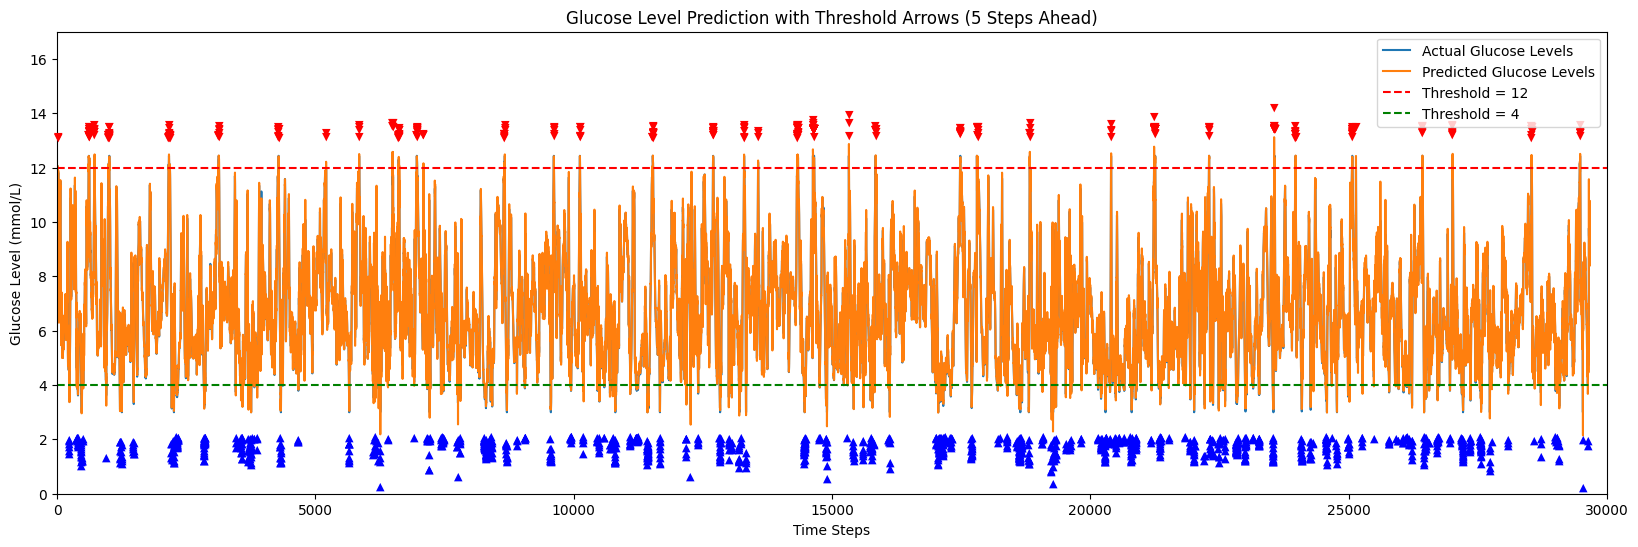

In [50]:
# Step 4: Plot the Results
plt.figure(figsize=(20, 6))

# Plot the actual glucose values from the test set
plt.plot(range(len(y_test_inverted)), y_test_inverted, label="Actual Glucose Levels")

# Plot the predicted glucose values
plt.plot(range(len(y_test_predict_inverted)), y_test_predict_inverted, label="Predicted Glucose Levels")

# Plot the threshold line
plt.axhline(y=threshold_high, color='red', linestyle='--', label=f"Threshold = {threshold_high}")
plt.axhline(y=threshold_low, color='green', linestyle='--', label=f"Threshold = {threshold_low}")

# Mark the points where the predicted glucose exceeds the threshold with arrows
for marker in markers_high:
    plt.text(marker, y_test_predict_inverted[marker] + 1, '▼', color='red', fontsize=8, ha='center')
for marker in markers_low:
    plt.text(marker, y_test_predict_inverted[marker] - 2, '▲', color='blue', fontsize=8, ha='center')
    
# Add labels and title
plt.xlim(0,30000)
plt.ylim(0, 17)
plt.xlabel("Time Steps")
plt.ylabel("Glucose Level (mmol/L)")
plt.title("Glucose Level Prediction with Threshold Arrows (5 Steps Ahead)")
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test = y_test_inverted.reshape(-1)
y_pred = y_test_predict_inverted.reshape(-1)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R^2 score (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Error (MAE): 0.12092581018314809
Mean Squared Error (MSE): 0.042738340796613344
Root Mean Squared Error (RMSE): 0.2067325344415178
R^2 Score: 0.9887157562207535
Mean Absolute Percentage Error (MAPE): 1.9223907335807144%
